# PART 2

# Necessary Imports

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

In [52]:
def plot_confusion_matrix(conf_mat, labels):
    classes = list(labels)
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()

def plot(x, y, xlabel, ylabel, title):
    plt.plot(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x)
    plt.show()

# Constants

In [53]:
CROSS_VALIDATION_SETS = 5
MAX_K = 10
RANDOM_STATE = 69
LABEL_NAMES = ['English', 'Urdu', 'Mixed']

# Loading Dataset and Splitting

In [54]:
data = pd.read_csv('dataset.csv')

train = data.sample(frac = 0.8, random_state = RANDOM_STATE)
test = data.drop(train.index)

train = train.to_numpy()
test = test.to_numpy()

train_x = train[:, 1:-1]
train_y = train[:, -1]

test_x = test[:, 1:-1]
test_y = test[:, -1]

In [55]:
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

train_x shape: (13904, 13)
train_y shape: (13904,)


In [56]:
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

test_x shape: (3476, 13)
test_y shape: (3476,)


# Exhaustively Finding Best Parameters

Setting Parameters 

In [57]:
C = [1, 10, 100]
gamma = [0.01, 0.1, 1]
degree = [3, 4, 5]

param_grid = [
   {'kernel': ['rbf', 'sigmoid'], 'C': C, 'gamma': gamma},
   {'kernel': ['poly'], 'C': C, 'gamma': gamma, 'degree': degree},
]

Searching for the best ones

In [58]:
start = time.time()

model = HalvingGridSearchCV(
    SVC(), 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=20,
    refit=True,
    verbose=3,
)
model.fit(train_x, train_y)

end = time.time()

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 514
max_resources_: 13904
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 45
n_resources: 514
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 15
n_resources: 1542
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 5
n_resources: 4626
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13878
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [59]:
time_taken = (end - start) / 60
print(f'Time Taken: {time_taken:.1f} Minutes')

Time Taken: 2.1 Minutes


Best Parameters

In [60]:
print("Best Validation Accuracy:", model.best_score_)
print("Best parameters:")
pprint.pprint(model.best_params_)

best_model = model.best_estimator_

Best Validation Accuracy: 0.8113020648622667
Best parameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


# 5 Fold CV on Best Parameters

In [61]:
clf = SVC(C=10, gamma=0.01, kernel='rbf')
clf.fit(train_x, train_y)

cv_scores = cross_val_score(clf, train_x, train_y, cv=CROSS_VALIDATION_SETS)

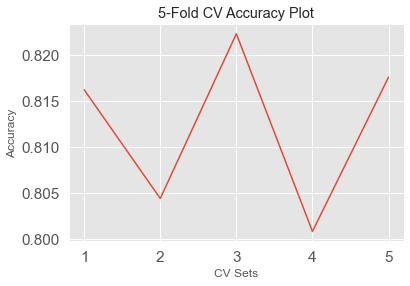

In [62]:
x = [x for x in range(1, CROSS_VALIDATION_SETS + 1)]

plot(x, cv_scores, 'CV Sets', 'Accuracy', '5-Fold CV Accuracy Plot')

# Running For Test Data

In [63]:
preds = best_model.predict(test_x)

Some Statistics

In [64]:
print(classification_report(test_y, preds, target_names=LABEL_NAMES))

              precision    recall  f1-score   support

     English       0.80      0.79      0.79      1072
        Urdu       0.83      0.78      0.80      1091
       Mixed       0.82      0.87      0.85      1313

    accuracy                           0.82      3476
   macro avg       0.82      0.81      0.81      3476
weighted avg       0.82      0.82      0.82      3476



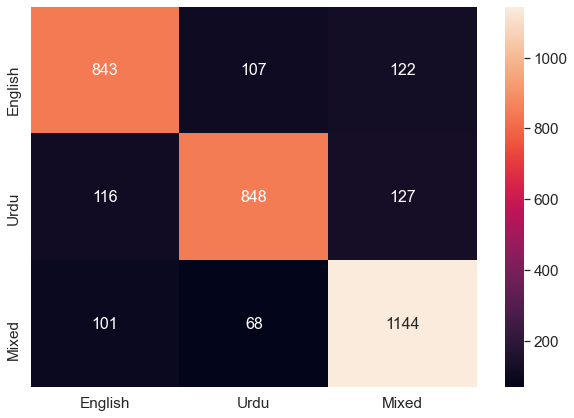

In [65]:
cfm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cfm, LABEL_NAMES)